In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt 
import seaborn as sns


In [2]:
pd.set_option('display.max_rows', 100)
df_x = pd.read_csv("/Users/macbookpro/Documents/Cours/Singapour/S2/Data discovery and data mining/Project/Project/Xtrain.csv",index_col='Id')
df_y = pd.read_csv("/Users/macbookpro/Documents/Cours/Singapour/S2/Data discovery and data mining/Project/Project/Ytrain.csv",index_col='Id')
df_test = pd.read_csv("/Users/macbookpro/Documents/Cours/Singapour/S2/Data discovery and data mining/Project/Project/Xtest.csv",index_col='Id',sep=";")
# Load the SBA loan data and make a copy for exploration

df = pd.concat([df_x,df_y],axis=1)
df_used_train = df.copy(deep=True)
print("Shape of dataframe {}".format(df_used_train.shape))
print(df_used_train.columns)
df_used_train

Shape of dataframe (50000, 24)
Index(['Name', 'City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS',
       'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob',
       'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc',
       'DisbursementDate', 'DisbursementGross', 'BalanceGross', 'GrAppv',
       'SBA_Appv', 'ChargeOff'],
      dtype='object')


,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,ChargeOff
Id,,,,,,,,,,,,,,,,,,,,,
0,"NPE Realty, LLC",Pembroke Pines,FL,33027,"TD BANK, NATIONAL ASSOCIATION",DE,334516,16-Apr-10,2010,130,...,0,1,N,N,1-May-10,"$2,000,000.00",$0.00,"$2,000,000.00","$1,500,000.00",0
1,"KEVCO CONSTRUCTION, LLC",SANDY,UT,84094,ZIONS FIRST NATIONAL BANK,UT,236115,30-Jan-10,2010,33,...,0,1,N,N,1-Feb-10,"$17,000.00",$0.00,"$17,000.00","$17,000.00",1
2,EAST L A SHOE REPAIR,LOS ANGELES,CA,90022,BANK OF AMERICA NATL ASSOC,NC,811430,29-Jul-02,2002,60,...,1,1,Y,N,31-Aug-02,"$17,000.00",$0.00,"$17,000.00","$8,500.00",0
3,"RUSSLER, DANIEL C, MD",LODI,WI,53555,ASSOCIATED BANK NATL ASSOC,WI,0,10-Jun-94,1994,160,...,1,0,N,N,31-Jul-94,"$137,000.00",$0.00,"$137,000.00","$123,300.00",0
4,AFFORDABLE FAMILY DENISTRY LLC,LEBANON,MO,65536,COMMERCE BANK,MO,621210,6-Feb-06,2006,101,...,1,1,T,N,31-Mar-06,"$46,665.00",$0.00,"$25,000.00","$12,500.00",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,WESTTOWN GULF,WEST CHESTER,PA,19382,CITIZENS BANK NATL ASSOC,RI,445120,29-Aug-03,2003,84,...,1,1,Y,N,30-Sep-03,"$46,231.00",$0.00,"$30,000.00","$15,000.00",0
49996,HS ELECTRIC,ENCINO,CA,91316,BANK OF AMERICA NATL ASSOC,NC,541513,12-Jul-04,2004,77,...,1,1,N,N,31-Jul-04,"$49,750.00",$0.00,"$50,000.00","$25,000.00",1
49997,"HARDIN GRAIN ELEVATOR, INC.",HARDIN,KY,42048,COMMUNITY FINAN SERVICES BK,KY,0,4-Oct-91,1992,223,...,1,0,N,N,31-Jan-92,"$260,000.00",$0.00,"$260,000.00","$221,000.00",0


In [3]:
#Clean types 
def clean_df(df_used_raw):
    df_used = df_used_raw.copy(deep=True)
    df_used = df_used.dropna(subset=['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv'])
    df_used[['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']] = df_used[['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']].astype('string')
    df_used[['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']] = df_used[['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', '').replace('.','')).astype('int64')
    
    df_used['ApprovalFY'] = df_used['ApprovalFY'].astype('string')
    df_used['ApprovalFY'] = df_used['ApprovalFY'].apply(lambda x: x.replace('A', '')).astype('int64')
    df_used['Industry'] = df_used['NAICS'].astype('str').apply(lambda x: x[:2])
    df_used['Industry'] = df_used['Industry'].map({
        '11': 'Ag/For/Fish/Hunt',
        '21': 'Min/Quar/Oil_Gas_ext',
        '22': 'Utilities',
        '23': 'Construction',
        '31': 'Manufacturing',
        '32': 'Manufacturing',
        '33': 'Manufacturing',
        '42': 'Wholesale_trade',
        '44': 'Retail_trade',
        '45': 'Retail_trade',
        '48': 'Trans/Ware',
        '49': 'Trans/Ware',
        '51': 'Information',
        '52': 'Finance/Insurance',
        '53': 'RE/Rental/Lease',
        '54': 'Prof/Science/Tech',
        '55': 'Mgmt_comp',
        '56': 'Admin_sup/Waste_Mgmt_Rem',
        '61': 'Educational',
        '62': 'Healthcare/Social_assist',
        '71': 'Arts/Entertain/Rec',
        '72': 'Accom/Food_serv',
        '81': 'Other_no_pub',
        '92': 'Public_Admin'
    })

   
    df_used['IsFranchised'] = df_used.FranchiseCode
    df_used[df_used['IsFranchised'] <= 1].IsFranchised = 0 
    df_used[df_used['IsFranchised'] > 1].IsFranchised = 1
    df_used = df_used[df_used['NewExist'].isin([1,2])]
    df_used['NewExist'] = df_used['NewExist'].astype('int64')

    df_used = df_used[df_used['UrbanRural'].isin([0,1,2])]
    df_used = df_used[df_used['LowDoc'].isin(['Y','N'])]
    #df_used = df_used[df_used['RevLineCr'].isin(['Y','N'])]
    df_used['RevLineCr'] = df_used['RevLineCr'].map({'Y': '1','N': '0','T':-1,'0':-1,np.nan:'-1','1':-1, 'Q':-1, 'R':-1, '2':-1}).astype('int64')
    df_used['LowDoc'] = df_used['LowDoc'].map({'Y': '1','N': '0','T':-1,'0':-1,np.nan:'-1'}).astype('int64')
    #df_used['RevLineCr'] = df_used['RevLineCr'].map({'Y': '1','N': '0'}).astype('int64')
    df_used[['ApprovalDate', 'DisbursementDate']] = df_used[['ApprovalDate', 'DisbursementDate']].apply(pd.to_datetime)
    df_used['DisFY'] = df_used['DisbursementDate'].map(lambda x: x.year).apply('int64')
    df_used['ratioApproved'] = df_used['SBA_Appv'] / df_used['GrAppv']
    df_used['ratioBankAmount'] = df_used['GrAppv'] / df_used['DisbursementGross']
    df_used.loc[df_used['GrAppv'] > df_used['DisbursementGross'],'BalanceComp'] = 1
    df_used.loc[df_used['GrAppv'] < df_used['DisbursementGross'],'BalanceComp'] = 2
    df_used.loc[df_used['GrAppv'] == df_used['DisbursementGross'],'BalanceComp'] = 0
    df_used.loc[df_used['BankState'] == df_used['State'],'FlagState'] = 1
    df_used.loc[df_used['BankState'] != df_used['State'],'FlagState'] = 0

    df_used['CreateJobPer'] = df_used['CreateJob'] / df_used['NoEmp']
    df_used['RetainedJobPer'] = df_used['RetainedJob'] / df_used['NoEmp']
    df_used['BalanceComp'].astype('int64')

    #Add features

    df_used['Terms_Cat'] = 0
    df_used.loc[(df_used['Term'] <= 1*12),'Terms_Cat']= 1
    df_used.loc[(df_used['Term'] > 1*12) & (df_used['Term'] <= 3*12),'Terms_Cat']= 2
    df_used.loc[(df_used['Term'] > 3*12) & (df_used['Term'] <= 5*12),'Terms_Cat']= 3
    df_used.loc[(df_used['Term'] > 5*12) & (df_used['Term'] <= 10*12),'Terms_Cat']= 4
    df_used.loc[(df_used['Term'] > 5*12) & (df_used['Term'] <= 10*12),'Terms_Cat']= 5
    df_used.loc[(df_used['Term'] > 10*12) & (df_used['Term'] <= 15*12),'Terms_Cat']= 6
    df_used.loc[(df_used['Term'] > 15*12) & (df_used['Term'] <= 20*12),'Terms_Cat']= 7
    df_used.loc[(df_used['Term'] >= 20*12) & (df_used['Term'] < 20*12),'Terms_Cat']= 8
    import datetime
    df_used['Offset'] = df_used['Term'].apply(lambda x: pd.DateOffset(months=x))
    df_used['Offset_end'] = df_used['DisbursementDate'] + df_used['Offset']
    df_used['IsActiveRecession'] = 0
    df_used.loc[(df_used['Offset_end'] >= datetime.datetime(year=2008, month=1, day=1)) & (df_used['Offset_end'] <= datetime.datetime(year=2009, month=6, day=1)),'IsActiveRecession']= 1
    #Advanced features: test small models with few features :
    #-> risk per industry
    #-> risk per year
    
    return df_used


In [4]:
df_train = clean_df(df_used_train)
df_train

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,ratioApproved,ratioBankAmount,BalanceComp,FlagState,CreateJobPer,RetainedJobPer,Terms_Cat,Offset,Offset_end,IsActiveRecession
Id,,,,,,,,,,,,,,,,,,,,,
0,"NPE Realty, LLC",Pembroke Pines,FL,33027,"TD BANK, NATIONAL ASSOCIATION",DE,334516,2010-04-16,2010,130,...,0.7500,1.000000,0.0,0.0,0.080000,0.0,6,<DateOffset: months=130>,2021-03-01,0
1,"KEVCO CONSTRUCTION, LLC",SANDY,UT,84094,ZIONS FIRST NATIONAL BANK,UT,236115,2010-01-30,2010,33,...,1.0000,1.000000,0.0,1.0,0.166667,0.5,2,<DateOffset: months=33>,2012-11-01,0
2,EAST L A SHOE REPAIR,LOS ANGELES,CA,90022,BANK OF AMERICA NATL ASSOC,NC,811430,2002-07-29,2002,60,...,0.5000,1.000000,0.0,0.0,1.000000,1.0,3,<DateOffset: months=60>,2007-08-31,0
3,"RUSSLER, DANIEL C, MD",LODI,WI,53555,ASSOCIATED BANK NATL ASSOC,WI,0,1994-06-10,1994,160,...,0.9000,1.000000,0.0,1.0,0.000000,0.0,6,<DateOffset: months=160>,2007-11-30,0
4,AFFORDABLE FAMILY DENISTRY LLC,LEBANON,MO,65536,COMMERCE BANK,MO,621210,2006-02-06,2006,101,...,0.5000,0.535733,2.0,1.0,3.500000,1.0,5,<DateOffset: months=101>,2014-08-31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,WESTTOWN GULF,WEST CHESTER,PA,19382,CITIZENS BANK NATL ASSOC,RI,445120,2003-08-29,2003,84,...,0.5000,0.648915,2.0,0.0,0.000000,1.0,5,<DateOffset: months=84>,2010-09-30,0
49996,HS ELECTRIC,ENCINO,CA,91316,BANK OF AMERICA NATL ASSOC,NC,541513,2004-07-12,2004,77,...,0.5000,1.005025,1.0,0.0,0.000000,1.0,5,<DateOffset: months=77>,2010-12-31,0
49997,"HARDIN GRAIN ELEVATOR, INC.",HARDIN,KY,42048,COMMUNITY FINAN SERVICES BK,KY,0,1991-10-04,1992,223,...,0.8500,1.000000,0.0,1.0,0.000000,0.0,7,<DateOffset: months=223>,2010-08-31,0


In [5]:
df_test = clean_df(df_test)
df_test

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,ratioApproved,ratioBankAmount,BalanceComp,FlagState,CreateJobPer,RetainedJobPer,Terms_Cat,Offset,Offset_end,IsActiveRecession
Id,,,,,,,,,,,,,,,,,,,,,
0,Bayridge Grocery Inc.,BROOKLYN,NY,11209.0,BANK OF AMERICA NATL ASSOC,NC,445110.0,2005-12-15,2006,47.0,...,0.50,0.833333,2.0,0.0,0.000000,1.0,3,<DateOffset: months=47.0>,2009-11-30,0
1,SUBWAY,GILBERT,AZ,85297.0,INDEPENDENCE BANK,RI,722211.0,2003-05-01,2003,120.0,...,0.85,1.000000,0.0,0.0,0.000000,0.0,5,<DateOffset: months=120.0>,2013-06-30,0
2,1-800 RADIATOR OF KATY,KATY,TX,77450.0,BANCO POPULAR NORTH AMERICA,NY,423120.0,2006-10-17,2007,98.0,...,0.75,1.000000,0.0,0.0,1.000000,1.0,5,<DateOffset: months=98.0>,2015-02-28,0
3,"DAUGHTERY'S FOOD&FUEL CTR, INC",JEFFERSONVILLE,KY,40337.0,"COMMUNITY TRUST BANK, INC.",KY,447110.0,2000-08-11,2001,120.0,...,0.75,1.687500,1.0,1.0,0.000000,0.0,5,<DateOffset: months=120.0>,2011-04-30,0
4,"TGGP ENTERPRISES, LLC",TWINSBURG,OH,44087.0,CAPITAL ONE NATL ASSOC,VA,722110.0,2005-10-27,2006,11.0,...,0.50,1.000000,0.0,0.0,0.111111,1.0,1,<DateOffset: months=11.0>,2006-11-30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Grand Forks Foot & Ankle Clini,Grand forks,ND,58201.0,CHOICE FINANCIAL GROUP,ND,621111.0,2009-08-06,2009,84.0,...,0.50,1.000000,0.0,1.0,0.000000,1.0,5,<DateOffset: months=84.0>,2017-01-01,0
99996,ASH PERFORMANCE MOTORSPORTS,MEDFORD,OR,97504.0,"READYCAP LENDING, LLC",CA,441310.0,2006-05-22,2006,88.0,...,0.75,1.000000,0.0,0.0,0.000000,0.0,5,<DateOffset: months=88.0>,2013-10-30,0
99997,Hiten Bhatt,LAFAYETTE,NJ,7878.0,UNITY BANK,NJ,445291.0,2004-08-23,2004,120.0,...,0.75,1.138952,1.0,1.0,4.000000,1.0,5,<DateOffset: months=120.0>,2014-09-30,0


In [6]:
def post_process(df_test,Industry=True):
    
    df_used_no_enhanced_features_test = df_test.copy(deep=True)
    print("Shape0:",df_used_no_enhanced_features_test.shape)
    if Industry:
        df_used_no_enhanced_features_test.drop(['Name', 'Zip', 'City','Bank','NAICS','ApprovalDate','DisbursementDate','Offset', 'Offset_end','FranchiseCode','Terms_Cat'],inplace=True,axis=1)
    else:
        df_used_no_enhanced_features_test.drop(['Name', 'Zip', 'Industry','City','Bank','NAICS','ApprovalDate','DisbursementDate','Offset', 'Offset_end','FranchiseCode','Terms_Cat'],inplace=True,axis=1)
    
    df_used_no_enhanced_features_test.fillna(-1,inplace=True)
    
    df_used_no_enhanced_features_test.dropna(inplace=True)
    df_used_no_enhanced_features_test
    print("Shape1:",df_used_no_enhanced_features_test.shape)
    
    all_states = list(set(list(df_used_no_enhanced_features_test['State'].unique())) | set(list(df_used_no_enhanced_features_test['BankState'].unique())))
    all_states_id = [i for i in range(len(all_states))]
    dict_map =  dict(zip(all_states, all_states_id))
    
    if Industry:
        all_industries = list(df_used_no_enhanced_features_test['Industry'])
        all_industries_id = [i for i in range(len(all_industries))]
        dict_ind_map =  dict(zip(all_industries, all_industries_id))
        df_used_no_enhanced_features_test['Industry'] = df_used_no_enhanced_features_test['Industry'].astype('category')
        df_used_no_enhanced_features_test['IndustryId'] = df_used_no_enhanced_features_test['Industry'].map(dict_ind_map).astype('int64')
        df_used_no_enhanced_features_test = df_used_no_enhanced_features_test.drop('Industry', axis=1)

    df_used_no_enhanced_features_test['BankState'] = df_used_no_enhanced_features_test['BankState'].astype('category')
    df_used_no_enhanced_features_test['State'] = df_used_no_enhanced_features_test['State'].astype('category')
   
    #print(df_used_no_enhanced_features_test.dtypes)
    df_used_no_enhanced_features_test

    df_used_no_enhanced_features_test['StateId'] = df_used_no_enhanced_features_test['State'].map(dict_map).astype('int64')
    df_used_no_enhanced_features_test['BankStateId'] = df_used_no_enhanced_features_test['BankState'].map(dict_map).astype('int64')
    
    df_used_no_enhanced_features_test = df_used_no_enhanced_features_test.drop('State', axis=1)
    df_used_no_enhanced_features_test = df_used_no_enhanced_features_test.drop('BankState', axis=1)
    
    
    return df_used_no_enhanced_features_test

df_used_no_enhanced_features_train = post_process(df_train,Industry=True)
df_used_no_enhanced_features_train_2 = post_process(df_train,Industry=False)
df_used_no_enhanced_features_test = post_process(df_test,Industry=True)
df_used_no_enhanced_features_test_2 = post_process(df_test,Industry=False)
#df_used_no_enhanced_features_test

Shape0: (49612, 37)
Shape1: (49612, 26)
Shape0: (49612, 37)
Shape1: (49612, 25)
Shape0: (99067, 36)
Shape1: (99067, 25)
Shape0: (99067, 36)
Shape1: (99067, 24)


In [8]:
df_used_no_enhanced_features_test_2

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,...,DisFY,ratioApproved,ratioBankAmount,BalanceComp,FlagState,CreateJobPer,RetainedJobPer,IsActiveRecession,StateId,BankStateId
Id,,,,,,,,,,,,,,,,,,,,,
0,2006,47.0,6.0,1,0.0,6.0,1.0,1,0,12000000,...,2005,0.50,0.833333,2.0,0.0,0.000000,1.0,0,7,39
1,2003,120.0,10.0,2,0.0,0.0,1.0,-1,1,13000000,...,2003,0.85,1.000000,0.0,0.0,0.000000,0.0,0,27,14
2,2007,98.0,1.0,2,1.0,1.0,1.0,-1,0,18400000,...,2006,0.75,1.000000,0.0,0.0,1.000000,1.0,0,40,7
3,2001,120.0,5.0,1,0.0,0.0,1.0,0,0,8000000,...,2001,0.75,1.687500,1.0,1.0,0.000000,0.0,0,25,25
4,2006,11.0,9.0,1,1.0,9.0,1.0,0,0,5000000,...,2005,0.50,1.000000,0.0,0.0,0.111111,1.0,0,47,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2009,84.0,5.0,1,0.0,5.0,1.0,0,0,35000000,...,2010,0.50,1.000000,0.0,1.0,0.000000,1.0,0,41,41
99996,2006,88.0,4.0,2,0.0,0.0,1.0,0,0,28600000,...,2006,0.75,1.000000,0.0,0.0,0.000000,0.0,0,6,42
99997,2004,120.0,2.0,2,8.0,2.0,1.0,-1,0,43900000,...,2004,0.75,1.138952,1.0,1.0,4.000000,1.0,0,48,48


## Training

In [7]:
print(list(df_used_no_enhanced_features_train.columns))
print(list(df_used_no_enhanced_features_train_2.columns))

df_used_no_enhanced_features_train = df_used_no_enhanced_features_train.replace([np.inf, -np.inf,np.finfo(np.float64).max], 0)
df_used_no_enhanced_features_train.astype('float64')

df_used_no_enhanced_features_train_2 = df_used_no_enhanced_features_train_2.replace([np.inf, -np.inf,np.finfo(np.float64).max], 0)
df_used_no_enhanced_features_train_2.astype('float64')

['ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv', 'ChargeOff', 'IsFranchised', 'DisFY', 'ratioApproved', 'ratioBankAmount', 'BalanceComp', 'FlagState', 'CreateJobPer', 'RetainedJobPer', 'IsActiveRecession', 'IndustryId', 'StateId', 'BankStateId']
['ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv', 'ChargeOff', 'IsFranchised', 'DisFY', 'ratioApproved', 'ratioBankAmount', 'BalanceComp', 'FlagState', 'CreateJobPer', 'RetainedJobPer', 'IsActiveRecession', 'StateId', 'BankStateId']


,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,...,DisFY,ratioApproved,ratioBankAmount,BalanceComp,FlagState,CreateJobPer,RetainedJobPer,IsActiveRecession,StateId,BankStateId
Id,,,,,,,,,,,,,,,,,,,,,
0,2010.0,130.0,25.0,1.0,2.0,0.0,1.0,0.0,0.0,200000000.0,...,2010.0,0.7500,1.000000,0.0,0.0,0.080000,0.0,0.0,22.0,52.0
1,2010.0,33.0,6.0,1.0,1.0,3.0,1.0,0.0,0.0,1700000.0,...,2010.0,1.0000,1.000000,0.0,1.0,0.166667,0.5,0.0,21.0,21.0
2,2002.0,60.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1700000.0,...,2002.0,0.5000,1.000000,0.0,0.0,1.000000,1.0,0.0,42.0,39.0
3,1994.0,160.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,13700000.0,...,1994.0,0.9000,1.000000,0.0,1.0,0.000000,0.0,0.0,10.0,10.0
4,2006.0,101.0,2.0,1.0,7.0,2.0,1.0,-1.0,0.0,4666500.0,...,2006.0,0.5000,0.535733,2.0,1.0,3.500000,1.0,0.0,31.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2003.0,84.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,4623100.0,...,2003.0,0.5000,0.648915,2.0,0.0,0.000000,1.0,0.0,14.0,12.0
49996,2004.0,77.0,6.0,1.0,0.0,6.0,1.0,0.0,0.0,4975000.0,...,2004.0,0.5000,1.005025,1.0,0.0,0.000000,1.0,0.0,42.0,39.0
49997,1992.0,223.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,26000000.0,...,1992.0,0.8500,1.000000,0.0,1.0,0.000000,0.0,0.0,25.0,25.0


In [9]:

from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
import numpy as np
#It tooks some time to run
from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
import matplotlib.pylab as pl
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [11]:


names = ["Nearest Neighbors", "SGD",
         "Decision Tree", "Random Forest", "AdaBoost",
         "Gassuian NB"]

classifiers = [
    KNeighborsClassifier(3),
    SGDClassifier(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=10, n_estimators=500),
    AdaBoostClassifier(),
    GaussianNB()]

# Scale the feature values prior to modeling
y_train = df_used_no_enhanced_features_train['ChargeOff']
X_train = df_used_no_enhanced_features_train.drop('ChargeOff', axis=1)
scale = StandardScaler()
X_scaled = scale.fit_transform(X_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=7)
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(name + str(score))
    print(metrics.classification_report(y_test, clf.predict(X_test)))

Nearest Neighbors0.7067714631197098
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      2463
           1       0.71      0.70      0.71      2499

    accuracy                           0.71      4962
   macro avg       0.71      0.71      0.71      4962
weighted avg       0.71      0.71      0.71      4962

SGD0.4951632406287787
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2463
           1       0.29      0.00      0.00      2499

    accuracy                           0.50      4962
   macro avg       0.39      0.50      0.33      4962
weighted avg       0.39      0.50      0.33      4962

Decision Tree0.8635630794034663
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2463
           1       0.88      0.84      0.86      2499

    accuracy                           0.86      4962
   macro avg       0.86      0.86     

### Go for ensemble learning (Random forest or Xgboost could do the trick)

In [ ]:
#Ada Boost grid search 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
 'n_estimators': [100, 200,500],
 'learning_rate' : [0.001,0.01,0.1,0.2,0.5],
 }

pre_gs_inst = RandomizedSearchCV(AdaBoostClassifier(),
 param_distributions = param_dist,
 cv=3,
 n_iter = 10,
 n_jobs=-1)

pre_gs_inst.fit(X_train, y_train)
pred_test =pre_gs_inst.predict(X_test)
print(metrics.classification_report(y_test, pred_test))

In [12]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y_train_global = df_used_no_enhanced_features_train['ChargeOff']
X_test = df_used_no_enhanced_features_test
X_train = df_used_no_enhanced_features_train.drop('ChargeOff', axis=1)
X_train.shape[0]
all_df = pd.concat([X_train,X_test])
all_df[['Term','NoEmp','CreateJob','RetainedJob','DisbursementGross','BalanceGross', 'GrAppv', 'SBA_Appv']] = scaler.fit_transform(all_df[['Term','NoEmp','CreateJob','RetainedJob','DisbursementGross','BalanceGross', 'GrAppv', 'SBA_Appv']])

X_train_scaled = all_df.iloc[[i for i in range(X_train.shape[0])],:]
X_test_scaled = all_df.iloc[[i for i in range(X_train.shape[0],all_df.shape[0])],:]
print(X_test_scaled.shape[0])
print(X_train_scaled.shape[0])
X_test_scaled

99067
49612


,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,...,ratioApproved,ratioBankAmount,BalanceComp,FlagState,CreateJobPer,RetainedJobPer,IsActiveRecession,IndustryId,StateId,BankStateId
Id,,,,,,,,,,,,,,,,,,,,,
0,2006,0.089184,0.0006,1,0.000000,0.000682,1.0,1,0,0.013341,...,0.50,0.833333,2.0,0.0,0.000000,1.0,0,99064,7,39
1,2003,0.227704,0.0010,2,0.000000,0.000000,1.0,-1,1,0.014452,...,0.85,1.000000,0.0,0.0,0.000000,0.0,0,99053,27,14
2,2007,0.185958,0.0001,2,0.000114,0.000114,1.0,-1,0,0.020456,...,0.75,1.000000,0.0,0.0,1.000000,1.0,0,99051,40,7
3,2001,0.227704,0.0005,1,0.000000,0.000000,1.0,0,0,0.008894,...,0.75,1.687500,1.0,1.0,0.000000,0.0,0,99064,25,25
4,2006,0.020873,0.0009,1,0.000114,0.001023,1.0,0,0,0.005559,...,0.50,1.000000,0.0,0.0,0.111111,1.0,0,99053,47,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2009,0.159393,0.0005,1,0.000000,0.000568,1.0,0,0,0.038911,...,0.50,1.000000,0.0,1.0,0.000000,1.0,0,99065,41,41
99996,2006,0.166983,0.0004,2,0.000000,0.000000,1.0,0,0,0.031795,...,0.75,1.000000,0.0,0.0,0.000000,0.0,0,99064,6,42
99997,2004,0.227704,0.0002,2,0.000909,0.000227,1.0,-1,0,0.048805,...,0.75,1.138952,1.0,1.0,4.000000,1.0,0,99064,48,48


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_train_global, test_size=0.25, random_state=4)

xgboost = XGBClassifier(random_state=2)
xgboost.fit(X_train, y_train)
y_xgbpred = xgboost.predict(X_test)
# Print the results
print(classification_report(y_test, y_xgbpred, digits=3))

              precision    recall  f1-score   support

           0      0.937     0.925     0.931      6241
           1      0.925     0.937     0.931      6162

    accuracy                          0.931     12403
   macro avg      0.931     0.931     0.931     12403
weighted avg      0.931     0.931     0.931     12403



In [14]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
xgb_model = xgb.XGBClassifier()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [8],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1000], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}


clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(n_splits=10, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(X_train_scaled, y_train_global)

report_best_scores(clf.cv_results_, 1)


# Trials and other experiments

### Decision Tree hyperparams

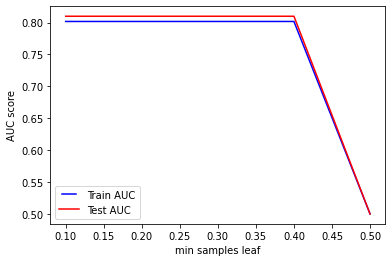

In [26]:
from sklearn.metrics import roc_curve, auc
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples leaf")
plt.show()

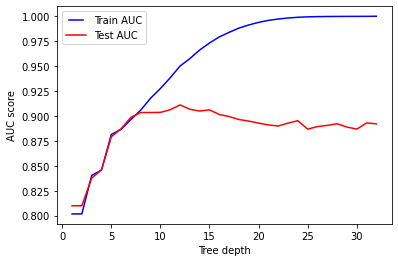

In [25]:
from sklearn.metrics import roc_curve, auc
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

### Random forests

In [27]:
# Scale the feature values prior to modeling
y_train = df_used_no_enhanced_features_train['ChargeOff']
X_train = df_used_no_enhanced_features_train.drop('ChargeOff', axis=1)
scale = StandardScaler()
X_scaled = scale.fit_transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=7)

forest = RandomForestClassifier(n_estimators=1000,
   criterion="gini", max_depth=None,
   min_samples_split=2, min_samples_leaf=1,
   max_features="auto", max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# apprentissage
forest = forest.fit(X_train,y_train)
print(1-forest.oob_score_)

# erreur de prévision sur le test 1-forest.score(X_test,y_test)
print(1-forest.score(X_test,y_test))
pred_test =forest.predict(X_test)
print(metrics.classification_report(y_test, pred_test))


0.09007746827097407
0.09048207663782448
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1937
           1       0.91      0.91      0.91      2108

    accuracy                           0.91      4045
   macro avg       0.91      0.91      0.91      4045
weighted avg       0.91      0.91      0.91      4045



### Xgboost 

In [19]:
xgboost = XGBClassifier(random_state=2)
xgboost.fit(X_train, y_train)
y_xgbpred = xgboost.predict(X_test)

# Print the results
print(classification_report(y_test, y_xgbpred, digits=3))

              precision    recall  f1-score   support

           0      0.938     0.927     0.933      1937
           1      0.934     0.944     0.939      2108

    accuracy                          0.936      4045
   macro avg      0.936     0.936     0.936      4045
weighted avg      0.936     0.936     0.936      4045



### Grid search to look for best model

In [ ]:


params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(3, 8), # default 3
    "n_estimators": randint(100, 200), # default 100
    "subsample": uniform(0.6, 0.4)
}

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=7)
xgb_model = xgb.XGBClassifier()
search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=300, cv=3, verbose=1, n_jobs=10, return_train_score=True)
search.fit(X_train, y_train)
report_best_scores(search.cv_results_, 1)

In [32]:


#report_best_scores(search.cv_results_, 1)

#print(classification_report(search.predict(X_test), y_test))

In [31]:

#Find best model on selected features

y_train = df_used_no_enhanced_features_train['ChargeOff']
X_train = df_used_no_enhanced_features_train.drop('ChargeOff', axis=1)
scale = StandardScaler()
X_scaled = scale.fit_transform(X_train)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(3, 7), # default 3
    "n_estimators": randint(50, 200), # default 100
    "subsample": uniform(0.6, 0.4)
}

# Train on all dataset 
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=7)
xgb_model = xgb.XGBClassifier()
search_1 = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=20, cv=5, verbose=1, n_jobs=4, return_train_score=True)
search_1.fit(X_scaled, y_train)
report_best_scores(search_1.cv_results_, 1)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  7.5min finished


NameError: name 'report_best_scores' is not defined

In [33]:
report_best_scores(search_1.cv_results_, 1)

Model with rank: 1
Mean validation score: 0.932 (std: 0.003)
Parameters: {'colsample_bytree': 0.7587948587257435, 'gamma': 0.022613644455269033, 'learning_rate': 0.1275990992289793, 'max_depth': 6, 'n_estimators': 131, 'subsample': 0.815876852955632}



In [38]:

#Find best model for the second part of the dataset with all features

y_train = df_used_no_enhanced_features_train_2['ChargeOff']
X_train = df_used_no_enhanced_features_train_2.drop('ChargeOff', axis=1)
scale_2 = StandardScaler()
X_scaled = scale_2.fit_transform(X_train)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(3, 7), # default 3
    "n_estimators": randint(50, 200), # default 100
    "subsample": uniform(0.6, 0.4)
}

# Train on all dataset 
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=7)
xgb_model_2 = xgb.XGBClassifier()
search_2 = RandomizedSearchCV(xgb_model_2, param_distributions=params, random_state=42, n_iter=20, cv=5, verbose=1, n_jobs=5, return_train_score=True)
search_2.fit(X_scaled, y_train)
report_best_scores(search_2.cv_results_, 1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  6.1min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed: 10.4min finished
Model with rank: 1
Mean validation score: 0.931 (std: 0.002)
Parameters: {'colsample_bytree': 0.8156249507619748, 'gamma': 0.007983126110107097, 'learning_rate': 0.0992681476866447, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.8733054075301833}



## Make predictions and gather them

In [50]:

model_1 = search_1.best_estimator_
model_2 = search_2.best_estimator_

df_used_no_enhanced_features_test = df_used_no_enhanced_features_test.replace([np.inf, -np.inf,np.finfo(np.float64).max], 0)
df_used_no_enhanced_features_test.astype('float64')
df_used_no_enhanced_features_test_2 = df_used_no_enhanced_features_test_2.replace([np.inf, -np.inf,np.finfo(np.float64).max], 0)
df_used_no_enhanced_features_test_2.astype('float64')

X_test= df_used_no_enhanced_features_test
X_test_2= df_used_no_enhanced_features_test_2

#Scaler should be the same with training data set be sure of that 
X_scaled_2 = scale_2.transform(X_test_2)
X_scaled = scale.transform(X_test)


y_test = model_1.predict(X_scaled)
y_test_2 = model_2.predict(X_scaled_2)

In [51]:

df_out = pd.DataFrame(data=list(y_test),index=list(df_used_no_enhanced_features_test.index),columns=["ChargeOff"])
df_out_2 = pd.DataFrame(data=list(y_test_2),index=list(df_used_no_enhanced_features_test_2.index),columns=["ChargeOff"])
df_out
df_out_2

,ChargeOff
0,1
1,0
2,1
3,0
4,1
...,...
99995,0
99996,1
99997,0
99998,0


In [52]:
#Gather predictions

df_out2 = pd.DataFrame(data=[np.nan for _ in range(100000)],index=[i for i in range(100000)],columns=["ChargeOff"])
df_out2.loc[list(df_out_2.index),'ChargeOff'] = df_out_2['ChargeOff']
df_out2.loc[list(df_out.index),'ChargeOff'] = df_out['ChargeOff']

df_out2["ChargeOff"] = df_out2["ChargeOff"].fillna(1)
df_out2["ChargeOff"] = df_out2["ChargeOff"].astype('int64')
df_out2["ChargeOff"] = df_out2["ChargeOff"]

In [53]:
#Write csv
df_out2.to_csv('SecondSubmit_3.csv',index=True,index_label='Id')

# TRASH

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
 'n_estimators': [100, 200,500],
 'learning_rate' : [0.001,0.01,0.1,0.2,0.5],
 }

pre_gs_inst = RandomizedSearchCV(AdaBoostClassifier(),
 param_distributions = param_dist,
 cv=3,
 n_iter = 10,
 n_jobs=-1)

pre_gs_inst.fit(X_train, y_train)
pred_test =pre_gs_inst.predict(X_test)
print(metrics.classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1937
           1       0.88      0.92      0.90      2108

    accuracy                           0.90      4045
   macro avg       0.90      0.89      0.89      4045
weighted avg       0.90      0.90      0.90      4045



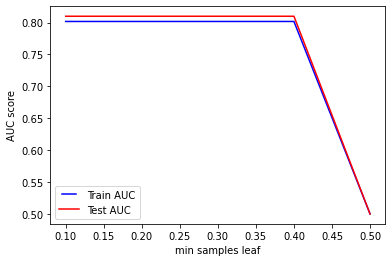

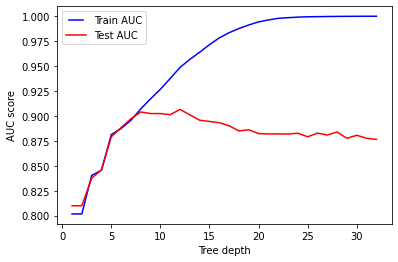

In [101]:
# Scale the feature values prior to modeling
y_train = df_used_no_enhanced_features_train['ChargeOff']
X_train = df_used_no_enhanced_features_train.drop('ChargeOff', axis=1)
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=7)

forest = RandomForestClassifier(n_estimators=1000,
   criterion="gini", max_depth=None,
   min_samples_split=2, min_samples_leaf=1,
   max_features="auto", max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# apprentissage
forest = forest.fit(X_train,y_train)
print(1-forest.oob_score_)

# erreur de prévision sur le test 1-forest.score(X_test,y_test)
print(1-forest.score(X_test,y_test))
pred_test =forest.predict(X_test)
print(metrics.classification_report(y_test, pred_test))


0.0951596066150211
0.09715698393077876
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1937
           1       0.91      0.91      0.91      2108

    accuracy                           0.90      4045
   macro avg       0.90      0.90      0.90      4045
weighted avg       0.90      0.90      0.90      4045



In [46]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report_best_scores(search.cv_results_, 1)

print(classification_report(search.predict(X_test), y_test))

Model with rank: 1
Mean validation score: 0.922 (std: 0.002)
Parameters: {'colsample_bytree': 0.7016566351370807, 'gamma': 0.4077307142274171, 'learning_rate': 0.24205720315428514, 'max_depth': 4, 'n_estimators': 134, 'subsample': 0.9085081386743783}

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1519
           1       0.94      0.93      0.94      1795

    accuracy                           0.93      3314
   macro avg       0.93      0.93      0.93      3314
weighted avg       0.93      0.93      0.93      3314



,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,LowDoc,DisbursementGross,BalanceGross,GrAppv,...,ratioBankAmount,BalanceComp,FlagState,CreateJobPer,RetainedJobPer,Terms_Cat,IsActiveRecession,StateId,BankStateId,IndustryId
Id,,,,,,,,,,,,,,,,,,,,,
13522,2006,3,2,0,0,1,0,13450000,0,16880000,...,1.255019,1.0,1.0,0.000000,0.0,5,0,47,47,40435
1906,2002,1,1,0,1,1,0,2150000,0,1050000,...,0.488372,2.0,0.0,0.000000,1.0,1,0,33,16,40445
28557,2006,7,1,1,7,2,0,2500000,0,2500000,...,1.000000,0.0,0.0,0.142857,1.0,5,0,51,39,40416
42747,2001,5,1,0,5,2,0,13300000,0,13300000,...,1.000000,0.0,1.0,0.000000,1.0,6,0,40,40,40444
11641,2004,2,1,0,2,2,0,53400000,0,53400000,...,1.000000,0.0,1.0,0.000000,1.0,0,0,6,6,40444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42202,2007,3,1,0,3,1,0,6714800,0,2500000,...,0.372312,2.0,0.0,0.000000,1.0,5,0,50,24,40445
17280,2007,1,2,2,1,1,0,15000000,0,15000000,...,1.000000,0.0,0.0,2.000000,1.0,5,0,50,6,40444
1138,2006,2,2,3,2,1,0,14500000,0,14500000,...,1.000000,0.0,0.0,1.500000,1.0,3,1,15,11,40438


In [39]:

# Scale the feature values prior to modeling
y_train = df_used_no_enhanced_features_train_2['ChargeOff']
X_train = df_used_no_enhanced_features_train_2.drop('ChargeOff', axis=1)
scale = StandardScaler()
X_scaled = scale.fit_transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=7)

xgboost = XGBClassifier(random_state=2)
xgboost.fit(X_train, y_train)
y_xgbpred = xgboost.predict(X_test)

# Print the results
print(classification_report(y_test, y_xgbpred, digits=3))

              precision    recall  f1-score   support

           0      0.929     0.935     0.932      2475
           1      0.934     0.928     0.931      2445

    accuracy                          0.931      4920
   macro avg      0.931     0.931     0.931      4920
weighted avg      0.931     0.931     0.931      4920



In [65]:
l = np.where(y_test != y_xgbpred)
X_test.iloc[list(l[0]),:]

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,LowDoc,DisbursementGross,BalanceGross,...,DisFY,ratioApproved,ratioBankAmount,BalanceComp,FlagState,CreateJobPer,RetainedJobPer,IsActiveRecession,StateId,BankStateId
Id,,,,,,,,,,,,,,,,,,,,,
34270,2002,36,1,1,0,0,2,0,16500000,0,...,2001,0.75,1.000000,0.0,1.0,0.0,0.0,0,27,27
29719,2008,36,5,2,0,5,1,0,5000000,0,...,2008,0.50,1.000000,0.0,1.0,0.0,1.0,0,41,41
24049,1998,137,28,1,0,0,0,0,32000000,0,...,1998,0.75,1.000000,0.0,1.0,0.0,0.0,0,11,11
43779,1997,36,1,1,0,0,0,0,5000000,0,...,1997,0.80,1.000000,0.0,0.0,0.0,0.0,0,18,43
6999,2006,36,15,1,0,15,1,0,2000000,0,...,2006,0.50,1.000000,0.0,0.0,0.0,1.0,1,18,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36037,2010,18,24,1,0,24,1,0,3500000,0,...,2010,0.85,1.000000,0.0,1.0,0.0,1.0,0,11,11
5971,2008,48,2,1,1,1,2,0,2600000,0,...,2008,0.50,1.000000,0.0,0.0,0.5,0.5,0,37,17
32723,2006,59,2,1,4,2,1,0,1650000,0,...,2006,0.50,0.727273,2.0,0.0,2.0,1.0,0,30,44


In [51]:

# Scale the feature values prior to modeling
y_train = df_used_no_enhanced_features_train['ChargeOff']
X_train = df_used_no_enhanced_features_train.drop('ChargeOff', axis=1)
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=7)

#xgboost = XGBClassifier(random_state=2)
#xgboost.fit(X_train, y_train)
y_xgbpred = search.best_estimator_.predict(X_test)

# Print the results
print(classification_report(y_test, y_xgbpred, digits=3))

NameError: name 'X' is not defined

In [71]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(3, 8), # default 3
    "n_estimators": randint(100, 200), # default 100
    "subsample": uniform(0.6, 0.4)
}

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=7)
xgb_model = xgb.XGBClassifier()
search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=100, cv=3, verbose=1, n_jobs=20, return_train_score=True)
search.fit(X_train, y_train)
report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   34.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  5.1min
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:  9.0min finished
Model with rank: 1
Mean validation score: 0.927 (std: 0.001)
Parameters: {'colsample_bytree': 0.7979622306417505, 'gamma': 0.2852219872026997, 'learning_rate': 0.1862502780077471, 'max_depth': 7, 'n_estimators': 179, 'subsample': 0.8989280440549523}



In [20]:
df_used_no_enhanced_features_test = df_used_test[['Name', 'City', 'State', 'Zip', 'Bank', 'BankState','ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob','RetainedJob', 'UrbanRural', 'RevLineCr', 'LowDoc','DisFY', 'DisbursementGross', 'BalanceGross', 'GrAppv','SBA_Appv', 'IsFranchised']]
df_used_no_enhanced_features_test.drop(['Name', 'Zip', 'City','Bank','RevLineCr'],inplace=True,axis=1)
df_used_no_enhanced_features_test.dropna(inplace=True)
#Get categorical data


df_used_no_enhanced_features_test['BankState'] = df_used_no_enhanced_features_test['BankState'].astype('category')
df_used_no_enhanced_features_test['State'] = df_used_no_enhanced_features_test['State'].astype('category')
print(df_used_no_enhanced_features_test.dtypes)
df_used_no_enhanced_features_test

df_used_no_enhanced_features_test['StateId'] = df_used_no_enhanced_features_test['State'].map(dict_map).astype('int64')
df_used_no_enhanced_features_test['BankStateId'] = df_used_no_enhanced_features_test['BankState'].map(dict_map).astype('int64')
df_used_no_enhanced_features_final_test = df_used_no_enhanced_features_test.drop('State', axis=1)
df_used_no_enhanced_features_final_test = df_used_no_enhanced_features_final_test.drop('BankState', axis=1)
df_used_no_enhanced_features_final_test

State                category
BankState            category
ApprovalFY              int64
Term                  float64
NoEmp                 float64
NewExist                int64
CreateJob             float64
RetainedJob           float64
UrbanRural            float64
LowDoc                  int64
DisFY                   int64
DisbursementGross       int64
BalanceGross            int64
GrAppv                  int64
SBA_Appv                int64
IsFranchised          float64
dtype: object


,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,LowDoc,DisFY,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,IsFranchised,StateId,BankStateId
Id,,,,,,,,,,,,,,,,
0,2006,47.0,6.0,1,0.0,6.0,1.0,0,2005,12000000,0,10000000,5000000,0.0,38,13
1,2003,120.0,10.0,2,0.0,0.0,1.0,1,2003,13000000,0,13000000,11050000,78760.0,28,20
2,2007,98.0,1.0,2,1.0,1.0,1.0,0,2006,18400000,0,18400000,13800000,407.0,47,38
3,2001,120.0,5.0,1,0.0,0.0,1.0,0,2001,8000000,0,13500000,10125000,1.0,48,48
4,2006,11.0,9.0,1,1.0,9.0,1.0,0,2005,5000000,0,5000000,2500000,0.0,31,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2009,84.0,5.0,1,0.0,5.0,1.0,0,2010,35000000,0,35000000,17500000,0.0,33,33
99996,2006,88.0,4.0,2,0.0,0.0,1.0,0,2006,28600000,0,28600000,21450000,1.0,15,50
99997,2004,120.0,2.0,2,8.0,2.0,1.0,0,2004,43900000,0,50000000,37500000,25650.0,29,29


In [ ]:
X = df_used_no_enhanced_features_final_test
scale = StandardScaler()
X_scaled = scale.fit_transform(X)


In [22]:
X = df_used_no_enhanced_features_final_test
scale = StandardScaler()
X_scaled = scale.fit_transform(X)




In [68]:
y_logpred_test = xgboost.predict(X_scaled)

In [60]:
y_logpred_test = clf.predict(X_test_scaled)

In [61]:
y_logpred_test

array([1, 0, 1, ..., 0, 0, 1])

In [69]:
df_out2 = pd.DataFrame(data=[np.nan for _ in range(100000)],index=[i for i in range(100000)],columns=["ChargeOff"])
df_out2.loc[list(df_out.index),'ChargeOff'] = df_out['ChargeOff']
df_out2["ChargeOff"] = df_out2["ChargeOff"].fillna(1)
df_out2["ChargeOff"] = df_out2["ChargeOff"].astype('int64')
df_out2["ChargeOff"] = df_out2["ChargeOff"]

In [77]:
df_out = pd.DataFrame(data=list(y_logpred_test),index=list(df_used_no_enhanced_features_final_test.index),columns=["ChargeOff"])
df_out



In [70]:
df_out2.to_csv('LastSubmit3.csv',index=True,index_label='Id')

In [71]:
df_out2.value_counts()

ChargeOff
1            50611
0            49389
dtype: int64

In [64]:
df_out = pd.DataFrame(data=list(y_logpred_test),index=list(X_test_scaled.index),columns=["ChargeOff"])
df_out

,ChargeOff
0,1
1,0
2,1
3,0
4,1
...,...
99995,0
99996,1
99997,0
99998,0


In [9]:
df_used_no_enhanced_features = df_train[['Name', 'City', 'State', 'Zip', 'Bank', 'BankState','ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob','RetainedJob', 'UrbanRural', 'RevLineCr', 'LowDoc','DisFY', 'DisbursementGross', 'BalanceGross', 'GrAppv','SBA_Appv', 'ChargeOff', 'IsFranchised']]
df_used_no_enhanced_features.drop(['Name', 'Zip', 'City','Bank','RevLineCr'],inplace=True,axis=1)

In [10]:
df_used_no_enhanced_features.dropna(inplace=True)
#Get categorical data
df_used_no_enhanced_features['BankState'] = df_used_no_enhanced_features['BankState'].astype('category')
df_used_no_enhanced_features['State'] = df_used_no_enhanced_features['State'].astype('category')

In [11]:
print(df_used_no_enhanced_features.dtypes)
df_used_no_enhanced_features

State                category
BankState            category
ApprovalFY              int64
Term                    int64
NoEmp                   int64
NewExist                int64
CreateJob               int64
RetainedJob             int64
UrbanRural              int64
LowDoc                  int64
DisFY                   int64
DisbursementGross       int64
BalanceGross            int64
GrAppv                  int64
SBA_Appv                int64
ChargeOff               int64
IsFranchised            int64
dtype: object


,State,BankState,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,LowDoc,DisFY,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,ChargeOff,IsFranchised
Id,,,,,,,,,,,,,,,,,
0,FL,DE,2010,130,25,1,2,0,1,0,2010,200000000,0,200000000,150000000,0,0
1,UT,UT,2010,33,6,1,1,3,1,0,2010,1700000,0,1700000,1700000,1,0
2,CA,NC,2002,60,1,1,1,1,1,0,2002,1700000,0,1700000,850000,0,1
3,WI,WI,1994,160,1,2,0,0,0,0,1994,13700000,0,13700000,12330000,0,1
4,MO,MO,2006,101,2,1,7,2,1,0,2006,4666500,0,2500000,1250000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,PA,RI,2003,84,1,1,0,1,1,0,2003,4623100,0,3000000,1500000,0,1
49996,CA,NC,2004,77,6,1,0,6,1,0,2004,4975000,0,5000000,2500000,1,1
49997,KY,KY,1992,223,1,1,0,0,0,0,1992,26000000,0,26000000,22100000,0,1


0    24932
1    24603
Name: ChargeOff, dtype: int64

In [12]:
all_states = list(set(list(df_used_no_enhanced_features['State'].unique())) | set(list(df_used_no_enhanced_features['BankState'].unique())))
all_states_id = [i for i in range(len(all_states))]
dict_map =  dict(zip(all_states, all_states_id))
df_used_no_enhanced_features['StateId'] = df_used_no_enhanced_features['State'].map(dict_map).astype('int64')
df_used_no_enhanced_features['BankStateId'] = df_used_no_enhanced_features['BankState'].map(dict_map).astype('int64')
df_used_no_enhanced_features_final = df_used_no_enhanced_features.drop('State', axis=1)
df_used_no_enhanced_features_final = df_used_no_enhanced_features_final.drop('BankState', axis=1)

In [13]:
df_used_no_enhanced_features_final

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,LowDoc,DisFY,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,ChargeOff,IsFranchised,StateId,BankStateId
Id,,,,,,,,,,,,,,,,,
0,2010,130,25,1,2,0,1,0,2010,200000000,0,200000000,150000000,0,0,24,19
1,2010,33,6,1,1,3,1,0,2010,1700000,0,1700000,1700000,1,0,45,45
2,2002,60,1,1,1,1,1,0,2002,1700000,0,1700000,850000,0,1,50,13
3,1994,160,1,2,0,0,0,0,1994,13700000,0,13700000,12330000,0,1,3,3
4,2006,101,2,1,7,2,1,0,2006,4666500,0,2500000,1250000,0,1,11,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2003,84,1,1,0,1,1,0,2003,4623100,0,3000000,1500000,0,1,25,20
49996,2004,77,6,1,0,6,1,0,2004,4975000,0,5000000,2500000,1,1,50,13
49997,1992,223,1,1,0,0,0,0,1992,26000000,0,26000000,22100000,0,1,48,48


NameError: name 'df_used_no_enhanced_features_final' is not defined

In [16]:
xgboost = XGBClassifier(random_state=2)

xgboost.fit(X_train, y_train)
y_xgbpred = xgboost.predict(X_val)

# Print the results
print(classification_report(y_val, y_xgbpred, digits=3))

              precision    recall  f1-score   support

           0      0.929     0.926     0.927      6175
           1      0.927     0.929     0.928      6209

    accuracy                          0.928     12384
   macro avg      0.928     0.928     0.928     12384
weighted avg      0.928     0.928     0.928     12384



## Correlation Analysis (to be completed)

In [93]:
df_correlation  = df_used.dropna()
df_correlation

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,...,DisbursementDate,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,ChargeOff,Industry,IsFranchised,DisbursementFY,BalanceComp
Id,,,,,,,,,,,,,,,,,,,,,
0,"NPE Realty, LLC",Pembroke Pines,FL,33027,"TD BANK, NATIONAL ASSOCIATION",DE,334516,2010-04-16,2010,130,...,2010-05-01,200000000,0,200000000,150000000,0,Manufacturing,0,2010,0.0
1,"KEVCO CONSTRUCTION, LLC",SANDY,UT,84094,ZIONS FIRST NATIONAL BANK,UT,236115,2010-01-30,2010,33,...,2010-02-01,1700000,0,1700000,1700000,1,Construction,0,2010,0.0
2,EAST L A SHOE REPAIR,LOS ANGELES,CA,90022,BANK OF AMERICA NATL ASSOC,NC,811430,2002-07-29,2002,60,...,2002-08-31,1700000,0,1700000,850000,0,Other_no_pub,1,2002,0.0
7,SA SA LLC,ELLICOTT CITY,MD,21043,HOWARD BANK,MD,423940,2010-01-15,2010,106,...,2010-02-01,7500000,0,7500000,6750000,1,Wholesale_trade,0,2010,0.0
9,Hoke Trucking Ltd.,Acranum,OH,45304,CALIFORNIA BANK & TRUST,CA,484121,2007-01-19,2007,10,...,2007-01-31,10000000,0,10000000,5000000,1,Trans/Ware,0,2007,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49989,UPTOWN NAILS,MODESTO,CA,95356,CAPITAL ONE NATL ASSOC,VA,812113,2006-11-01,2007,59,...,2007-01-31,3152600,0,2500000,1250000,1,Other_no_pub,0,2007,2.0
49991,GOLD COAST TRADING COMPANY,HUNTINGTON BEACH,CA,92646,U.S. BANK NATIONAL ASSOCIATION,CA,451110,1995-08-29,1995,120,...,1995-10-31,7000000,0,7000000,6300000,0,Retail_trade,1,1995,0.0
49995,WESTTOWN GULF,WEST CHESTER,PA,19382,CITIZENS BANK NATL ASSOC,RI,445120,2003-08-29,2003,84,...,2003-09-30,4623100,0,3000000,1500000,0,Retail_trade,1,2003,2.0


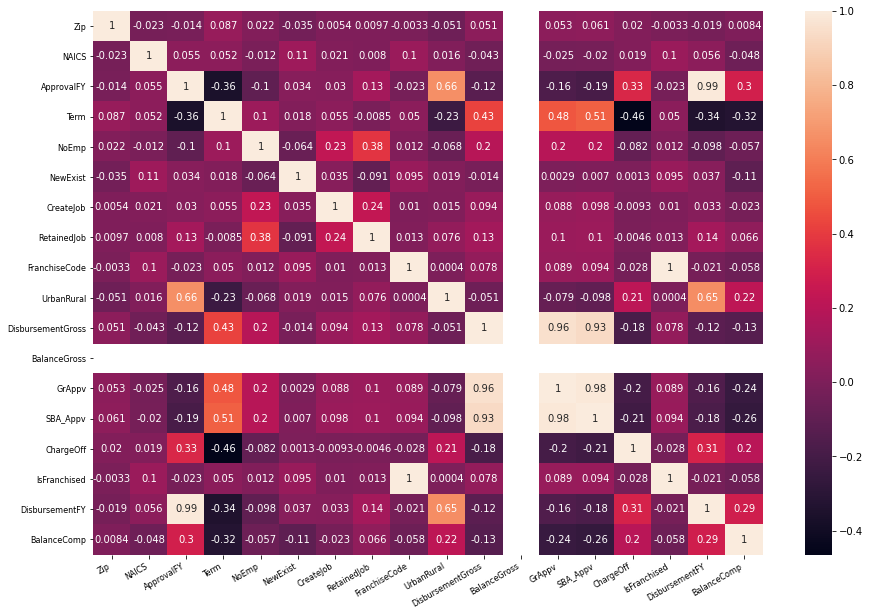

In [94]:
# Correlation Matrix

cor_fig, cor_ax = plt.subplots(figsize=(15, 10))
corr_matrix = df_correlation.corr()
cor_ax = sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=30, horizontalalignment='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [14]:
#Nan values cleanings 
#We will not use these fields:

df_copy.drop(subset=['Name','City','Bank', 'BankState', 'ApprovalDate','Term', 'LowDoc', 'DisbursementDate', 'MIS_Status'], inplace=True)
df_used.isnull().sum()

Name                   1
City                   0
State                  0
Zip                    0
Bank                  76
BankState             77
NAICS                  0
ApprovalDate           0
ApprovalFY             0
Term                   0
NoEmp                  0
NewExist               7
CreateJob              0
RetainedJob            0
FranchiseCode          0
UrbanRural             0
RevLineCr            153
LowDoc               172
DisbursementDate     119
DisbursementGross      0
BalanceGross           0
GrAppv                 0
SBA_Appv               0
ChargeOff              0
dtype: int64

{'cv': StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
 'error_score': nan,
 'estimator__objective': 'binary:logistic',
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__gamma': None,
 'estimator__gpu_id': None,
 'estimator__importance_type': 'gain',
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__num_parallel_tree': None,
 'estimator__random_state': None,
 'estimator__reg_alpha': None,
 'estimator__reg_lambda': None,
 'estimator__scale_pos_weight': None,
 'estimator__subsample': None,
 'estimator__tree_method': None,
 'estimator__validate_parameters': None,


array([1, 0, 1, ..., 0, 0, 1])

In [59]:
X_test_scaled.shape[0]

99067